In [1]:
import torch
import pandas as pd
import numpy as np
import albumentations as ATransforms
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
# from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF

import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Hyperparameters

In [3]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_WORKERS = 4

LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_FILE = "../models/model-1.pth"

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3


## Model Architecture

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
class UNET(nn.Module):
    def __init__(self, in_channels=IMAGE_CHANNELS, out_channels=IMAGE_CHANNELS):
        super(UNET, self).__init__()
        self.conv1 = DoubleConv(in_channels, 64)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = DoubleConv(1024, 512)
        self.conv7 = DoubleConv(512, 256)
        self.conv8 = DoubleConv(256, 128)
        self.conv9 = DoubleConv(128, 64)

        self.tconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(1024, 1024)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        c1 = self.conv1(x)
        skip_connections.append(c1)
        c2 = self.conv2(self.maxpool(c1))
        skip_connections.append(c2)
        c3 = self.conv3(self.maxpool(c2))
        skip_connections.append(c3)
        c4 = self.conv4(self.maxpool(c3))
        skip_connections.append(c4)
        out = self.conv5(self.maxpool(c4))
        out = self.bottleneck(out)
        skip_connections = skip_connections[::-1]
        out = self.tconv1(out)
        if out.shape != skip_connections[0].shape:
            out = TF.resize(out, size=skip_connections[0].shape[2:])
        out = torch.cat([out, skip_connections[0]], dim=1)
        out = self.conv6(out)

        out = self.tconv2(out)
        if out.shape != skip_connections[1].shape:
            out = TF.resize(out, size=skip_connections[1].shape[2:])
        out = torch.cat((out, skip_connections[1]), dim=1)
        out = self.conv7(out)

        out = self.tconv3(out)
        if out.shape != skip_connections[2].shape:
            out = TF.resize(out, size=skip_connections[2].shape[2:])
        out = torch.cat((out, skip_connections[2]), dim=1)
        out = self.conv8(out)

        out = self.tconv4(out)
        if out.shape != skip_connections[3].shape:
            out = TF.resize(out, size=skip_connections[3].shape[2:])
        out = torch.cat((out, skip_connections[3]), dim=1)
        out = self.conv9(out)

        out = self.out(out)
        return out
    




## Dataloader Preparation

In [6]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, normalize=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.normalize = normalize
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask > 0] = 1 # try with mask == 255.0
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        if self.normalize is not None:
            image = self.normalize(image)

        return image, mask

In [7]:
augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ATransforms.Rotate(limit=35, p=1.0),
    ATransforms.HorizontalFlip(p=0.5),
    ATransforms.VerticalFlip(p=0.1),
    ToTensorV2(),
])

normalization = ATransforms.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            )

val_augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

In [8]:
train_loader = DataLoader(
    PolypDataset('../data/train/images/', '../data/train/masks', transform=augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    PolypDataset('../data/val/images/', '../data/val/masks', transform=val_augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    PolypDataset('../data/test/images/', '../data/test/masks'),
    batch_size = 1,
    shuffle = True,
    num_workers=NUM_WORKERS
)

## Train

In [9]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
if LOAD_MODEL : model.load_state_dict(torch.load(CHECKPOINT_FILE, map_location=DEVICE), strict=False)

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, bce=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.bce = bce

    def forward(self, pred, target):
        loss = self.IoU(pred, target) # IoU score
        loss = 1 - loss.mean() # mean over the batch
        if self.bce:
            criterion = nn.BCEWithLogitsLoss()
            bce = criterion(pred, target)
            loss += bce.mean()
        return loss
        
    def IoU(self, pred, target):
        intersection = ((pred * target) + self.smooth).sum(dim=(1,2)) # we are passig as batch of images, so sum only across height and width
        union = (pred + target + self.smooth).sum(dim=(1,2))
        return (intersection + self.smooth) / (union - intersection + self.smooth)

In [11]:
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-7)


In [18]:
def train():
    all_losses = []
    all_val_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        print(f"Epoch {epoch+1}/{EPOCHS}")
        model.train()
        for data, targets in tqdm(train_loader, "Training"):
            data = data.to(device=DEVICE)
            # targets = targets.float().unsqueeze(1).to(device=DEVICE)
            targets = targets.unsqueeze(1).to(DEVICE) # add channels dimension
            scores = model(data)
            loss = criterion(scores, targets)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        all_losses.append(total_loss)
        # torch.save(model.state_dict(), CHECKPOINT_FILE)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for image, mask in tqdm(val_loader, "Validation"):
                image = image.to(device=DEVICE)
                mask = mask.unsqueeze(1).to(DEVICE)
                pred = model(image)
                # pred = torch.sigmoid(model(image))
                # preds = (preds > 0.5).float()
                loss = criterion(pred, mask)
                total_val_loss += loss.item()
        all_val_losses.append(total_val_loss)
        print(f"Train loss: {total_loss/len(train_loader)}, Val loss: {total_val_loss/len(val_loader)}\n")

    return all_losses, all_val_losses



In [19]:
train_loss, val_loss = train()

Epoch 1/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Train loss: 2.0445097992344508, Val loss: 1.9523288011550903

Epoch 2/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Train loss: 1.913693969211881, Val loss: 1.6879380771092005

Epoch 3/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Train loss: 2.5710290045965287, Val loss: 1.8800700732639857

Epoch 4/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Train loss: 3.1406836358327714, Val loss: 2.22631904057094

Epoch 5/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Train loss: 1.954667155704801, Val loss: 2.077344162123544

Epoch 6/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Train loss: 2.5211873518096075, Val loss: 1.7491332122257777

Epoch 7/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Train loss: 2.3867068309632558, Val loss: 2.1311616556985036

Epoch 8/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Train loss: 2.387240917909713, Val loss: 1.7012920805386134

Epoch 9/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Train loss: 2.3130868124583412, Val loss: 2.1701299803597585

Epoch 10/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Train loss: 3.3517152052077037, Val loss: 2.171014870916094

Epoch 11/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Train loss: 2.522289788912213, Val loss: 2.2688092844826833

Epoch 12/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Train loss: 3.717105355527666, Val loss: 1.7082802312714713

Epoch 13/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Train loss: 2.397950803476667, Val loss: 2.0278245891843523

Epoch 14/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Train loss: 1.3215741108334254, Val loss: 1.906510284968785

Epoch 15/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Train loss: 2.2457634948548817, Val loss: 2.012899705341884

Epoch 16/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Train loss: 1.8860107244007172, Val loss: 1.9589932731219701

Epoch 17/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Train loss: 2.273460164902702, Val loss: 1.9334760223116194

Epoch 18/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Train loss: 2.2872349714475964, Val loss: 1.9429945605141776

Epoch 19/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Train loss: 4.764994184176127, Val loss: 1.6777986117771693

Epoch 20/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Train loss: 3.415222934314183, Val loss: 2.2664872237614224

Epoch 21/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Train loss: 2.714141589308542, Val loss: 2.281567539487566

Epoch 22/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Train loss: 2.201415615422385, Val loss: 1.982656444822039

Epoch 23/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Train loss: 1.8838816796030318, Val loss: 2.189922945840018

Epoch 24/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Train loss: 1.8841434300891937, Val loss: 2.264758348464966

Epoch 25/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Train loss: 2.089823560109214, Val loss: 2.168283070836748

Epoch 26/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Train loss: 2.855102052764287, Val loss: 2.3159305197852

Epoch 27/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Train loss: 2.0906016050823153, Val loss: 2.3373569079807828

Epoch 28/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Train loss: 2.028284585665143, Val loss: 1.9963848420551844

Epoch 29/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Train loss: 2.6110224458906384, Val loss: 1.6942776952471053

Epoch 30/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Train loss: -0.38019924315195236, Val loss: 2.0318575416292464

Epoch 31/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Train loss: 3.9716828938514466, Val loss: 6.837982075554984

Epoch 32/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Train loss: 2.4405479601451328, Val loss: 2.436528205871582

Epoch 33/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Train loss: 2.3434937113807317, Val loss: 0.8794299704687936

Epoch 34/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Train loss: -1.559041472654494, Val loss: 2.4059842314038957

Epoch 35/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Train loss: 2.9792479664560347, Val loss: 2.3417103460856845

Epoch 36/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Train loss: 3.138647910148378, Val loss: 2.2609638145991733

Epoch 37/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Train loss: -1.3644022468536618, Val loss: 2.114342059407915

Epoch 38/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


Train loss: 2.0531528620492843, Val loss: 2.054542967251369

Epoch 39/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Train loss: 8.387194954213642, Val loss: 2.160795177732195

Epoch 40/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Train loss: 2.4125235847064426, Val loss: 2.2142162322998047

Epoch 41/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Train loss: 3.3560119441577365, Val loss: 2.120915344783238

Epoch 42/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Train loss: 3.1786603795157538, Val loss: 9.675436871392387

Epoch 43/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Train loss: 2.1967612448192777, Val loss: 2.074207033429827

Epoch 44/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Train loss: 3.086667340899271, Val loss: 2.9262776034218922

Epoch 45/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Train loss: 1.4964428969791956, Val loss: 2.240551778248378

Epoch 46/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Train loss: 2.519517469973791, Val loss: 2.1716823237282887

Epoch 47/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Train loss: 3.6928442565221635, Val loss: 3.1223497901644026

Epoch 48/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Train loss: 2.4141759191240584, Val loss: 2.1356829575129916

Epoch 49/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Train loss: 2.1032725061689104, Val loss: 2.4194102457591464

Epoch 50/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

Train loss: 2.887282703604017, Val loss: 2.6030679770878384



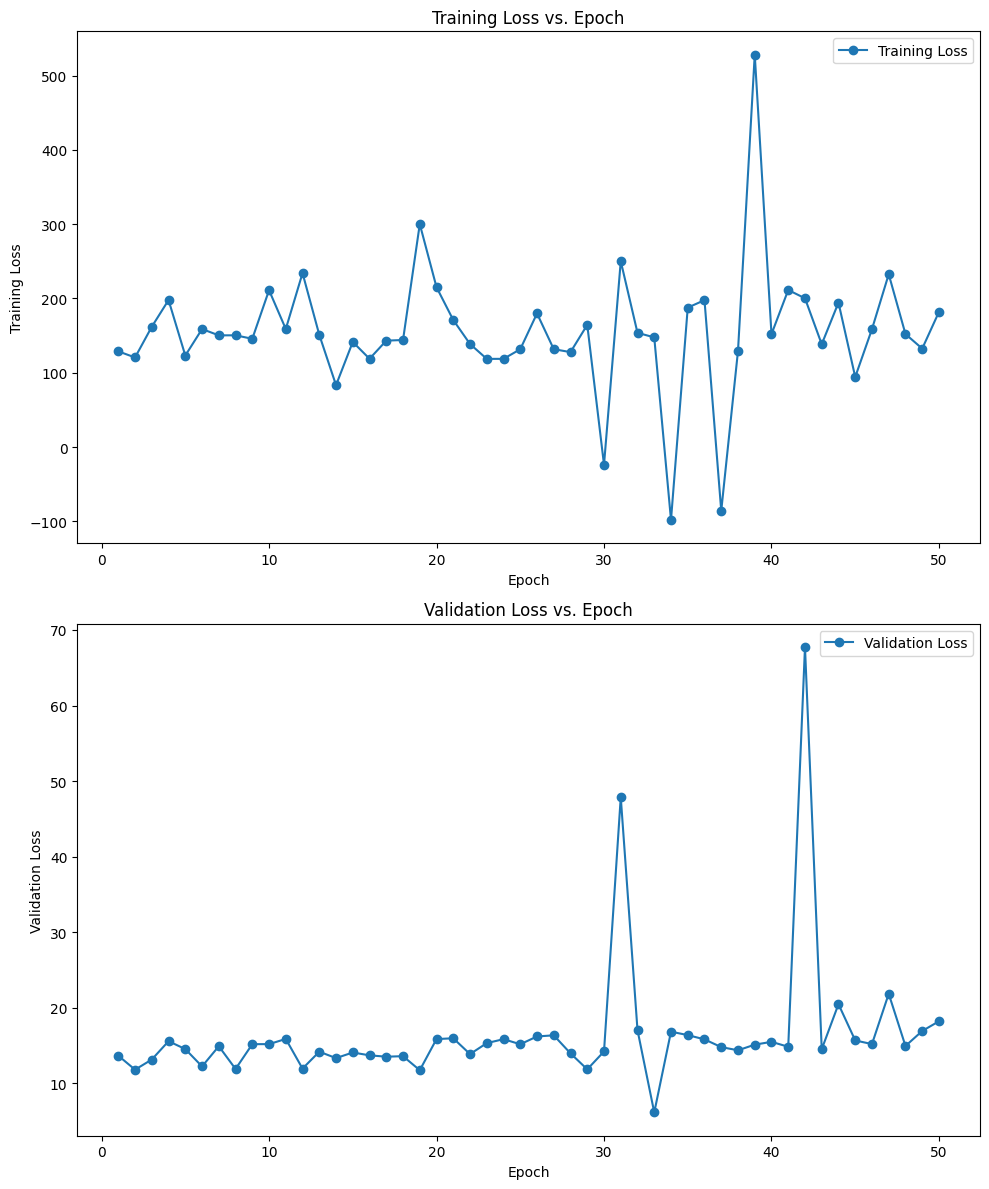

In [20]:
def plot_losses(train_loss, validation_loss):
    # Create an array of epoch numbers based on the length of the lists
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots for train loss, validation loss, and BLEU scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot training loss
    ax1.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss vs. Epoch')
    ax1.legend()

    # Plot validation loss
    ax2.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss vs. Epoch')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_losses(train_loss, val_loss)

In [ ]:
torch.save(model.state_dict(), '../models/model-1.pth')

## Test

In [ ]:
# def evaluate(model, loader):
#     model.eval()
#     total = 0
#     correct = 0
#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(DEVICE)
#             y = y.unsqueeze(1).to(DEVICE)
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#             total += y.flatten().size(0)
#             correct += (preds == y).float().sum().item()
#     return correct / total